# RNA-seq exercises
For this exercise, we will go through the main steps of differential expression analysis, including:<br>
a) Retrieving Samples information<br>
b) Alignment to a reference genome<br>
c) Read count<br>
c) Statistical analyses<br>

### General samples information
Use SRA (Sequence Read Archive; https://www.ncbi.nlm.nih.gov/sra) to retrieve information about
these two samples with the following accession numbers: SRR057656 and SRR057642. For each
accession number you will have a specific page with several information and useful links (e.g. GEO
Web Link)
Using the information you will find, try to answer to the following questions:

**Q1: For which study were they generated?** <br>



**Q2: How many bases were generated for each run?** <br>


**Q3: Which sample is the case and which sample is the control?**<br>


**Q4: Is it single-end or paired end sequencing?**<br>


**Q5: What can you tell about the extraction method and the data generation of both samples?**<br>



**Reads alignment**

Now we know what kind of samples we are analyzing. Because of limited power/students and time,
we will work assuming these files have been already filtered and trimmed according with what you
have already learnt in the previous lectures. Moreover, we will consider only the chr9 that contains the
PCA3 gene. This gene produces a spliced, long non-coding RNA that is highly overexpressed in most
types of prostate cancer cells and is used as a specific biomarker for this type of cancer through the
analysis of peripheral blood and urine.
All the files you will need can be also found on the following directory:
/exercises/rnaseq2
Because they are derived by paired-end sequencing, you will see two fastq files for each sample.

HiSat2 is the next development of TopHat2. To use it we need to index our reference (chr9).

1) Let us create a symbolink link the reference sequence for chromosome 9:


In [3]:
!cd
!rm -Rf ex_rnaseq
!mkdir ex_rnaseq
%cd ex_rnaseq
!ln -s /exercises/rnaseq2/GRCh38_Chr9.fasta ./GRCh38_Chr9.fasta
!pwd
!ls

/home/jupyter-ngs_user_23/ex_rnaseq/ex_rnaseq/ex_rnaseq
/home/jupyter-ngs_user_23/ex_rnaseq/ex_rnaseq/ex_rnaseq
GRCh38_Chr9.fasta


2) Let's build the indexed reference, 


In [ ]:
!hisat2-build GRCh38_Chr9.fasta GRCh38_Chr9


Now we are ready to do the alignment. Choose one sample eg. here he chose the affected samples. You do not need to copy your fastq files in your directory, simply recall them from the directory in which they are stored

In [8]:
%%bash
hisat2 -x GRCh38_Chr9 -1 /exercises/rnaseq2/SRR057642_chr9-1.fastq \
    -2 /exercises/rnaseq2/SRR057642_chr9-2.fastq> affected.sam

1562296 reads; of these:
  1562296 (100.00%) were paired; of these:
    799488 (51.17%) aligned concordantly 0 times
    717734 (45.94%) aligned concordantly exactly 1 time
    45074 (2.89%) aligned concordantly >1 times
    ----
    799488 pairs aligned concordantly 0 times; of these:
      25180 (3.15%) aligned discordantly 1 time
    ----
    774308 pairs aligned 0 times concordantly or discordantly; of these:
      1548616 mates make up the pairs; of these:
        579457 (37.42%) aligned 0 times
        533726 (34.46%) aligned exactly 1 time
        435433 (28.12%) aligned >1 times
81.45% overall alignment rate


Look at the output you have in the screen after the alignment. It provides some statistics about the alignment. Reply to Q6-Q9 based on this output.


<b>Q6. how many reads were paired?</b>

<b>Q7: how many read pairs have multi mapping sites?</b>


<b>Q8: how many read pairs have been mapped exactly one time?</b>


<b>Q9: what is the overall alignment rate?</b>


We then convert the sam files in bam files that will be used for the next analyses. This file should be sorted not by position, but by read name, to that each pair is consecutive.


In [10]:
!samtools view  affected.sam -Sb | samtools sort -n  > affected.bam

[bam_sort_core] merging from 1 files and 1 in-memory blocks...


Now we are ready to do the counting of how many reads map to each gene/transcript. For this, we use HTSeq. 

Type htseq-count --help to see what options you can use. 
HTseq needs a bam-file with the RNA alignments as input (which we just made) and a gtf or gff file that contains 
information on where the different exons and transcripts are on chr9. Copy the gff file (chr9.gff) in your working directory, try to look at it (using the command “head”). 

You will see that it contains information on the transcripts and the different exons.


In [12]:
!rm chr9.gff
!ln -s /exercises/rnaseq2/chr9.gff .
!head chr9.gff

rm: cannot remove 'chr9.gff': No such file or directory
##sequence-region NC_000009.12 1 138394717
##species https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=9606
NC_000009.12	RefSeq	region	1	138394717	.	+	.	ID=id891813;Dbxref=taxon:9606;Name=9;chromosome=9;gbkey=Src;genome=chromosome;mol_type=genomic DNA
NC_000009.12	BestRefSeq	pseudogene	11987	14525	.	+	.	ID=gene24997;Dbxref=GeneID:100287596,HGNC:HGNC:37106;Name=DDX11L5;description=DEAD/H-box helicase 11 like 5;gbkey=Gene;gene=DDX11L5;gene_biotype=transcribed_pseudogene;pseudo=true
NC_000009.12	BestRefSeq	transcript	11987	14525	.	+	.	ID=rna73405;Parent=gene24997;Dbxref=GeneID:100287596,Genbank:NR_051986.1,HGNC:HGNC:37106;Name=NR_051986.1;gbkey=misc_RNA;gene=DDX11L5;product=DEAD/H-box helicase 11 like 5;transcript_id=NR_051986.1
NC_000009.12	BestRefSeq	exon	11987	12340	.	+	.	ID=id891814;Parent=rna73405;Dbxref=GeneID:100287596,Genbank:NR_051986.1,HGNC:HGNC:37106;gbkey=misc_RNA;gene=DDX11L5;product=DEAD/H-box helicase 11 like

HTseq will output the counts in two columns with <i>column1=gene</i> and <i>column2=#reads</i>, we will put that in two files called affetcted.counts.txt or control.counts.txt. 

In [20]:
! htseq-count -f bam -s yes -m intersection-strict --idattr=gene affected.bam chr9.gff > affected.counts.txt

100000 GFF lines processed.
152461 GFF lines processed.
100000 BAM alignment record pairs processed.
200000 BAM alignment record pairs processed.
300000 BAM alignment record pairs processed.
400000 BAM alignment record pairs processed.
500000 BAM alignment record pairs processed.
600000 BAM alignment record pairs processed.
700000 BAM alignment record pairs processed.
800000 BAM alignment record pairs processed.
900000 BAM alignment record pairs processed.
1000000 BAM alignment record pairs processed.
1100000 BAM alignment record pairs processed.
1200000 BAM alignment record pairs processed.
1300000 BAM alignment record pairs processed.
1400000 BAM alignment record pairs processed.
1500000 BAM alignment record pairs processed.
1562296 BAM alignment pairs processed.


The 2-column file output contains the number of reads aligned to each genomic features on chromosome 9. Using standard UNIX tools, it is possible to look at this output.

In [17]:
!head affected.counts.txt

!tail affected.counts.txt

AAED1	31
ABCA1	148
ABCA2	1211
ABHD17B	95
ABL1	778
ABO	3
ACER2	154
ACO1	285
ACTG1P14	259
ACTG1P19	101
ZNF658	15
ZNF658B	2
ZNF782	46
ZNF79	43
ZNF883	3
__no_feature	477314
__ambiguous	2353
__too_low_aQual	524107
__not_aligned	8159
__alignment_not_unique	262911


<b>Q10: How many total reads are counted in the genomic features? </b>


<b>Q11. What is the raw read count for PCA3 gene in your sample?</b>


***STATISTICAL ANALYSES***

We will now perform differential expression among all the affected and control samples of the project. In this case, read count was performed using transcript accession numbers from Ensembl.

Copy the directory "counts" in your working directory, then enter in the directory



In [21]:
%cd ~/ex_rnaseq/
! cp -r /exercises/rnaseq2/counts .
%cd ~/ex_rnaseq/counts


/home/jupyter-ngs_user_23/ex_rnaseq
/home/jupyter-ngs_user_23/ex_rnaseq/counts


<b> The following analyses will be run using R. The commented code is reported here, but we will run this R script using the bash command line 

In the code, we have omitted the ENSG id for the gene PCA3. This kind of id are gene ids from Ensembl. 
To figure out which what the id is for PCA3 you need to go to the Ensembl-website and search for PCA3. 

<b> Q12 What is the ENSG identifier for PCA3?</b>

Now, let's run the R code and display the PCA3.jpg graph

In [22]:
!cp /home/jupyter-sdc_admin/exercise_day4.R .

! /usr/bin/Rscript exercise_day4.R


cp: missing destination file operand after '/home'
Try 'cp --help' for more information.
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, un

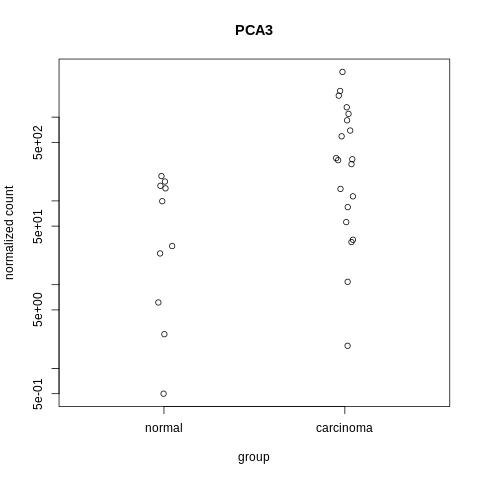

In [23]:
from IPython.display import Image

Image(filename='PCA3.jpeg') 

<b>Q13: Are the counts as expected from your knowledge about PCA3? Why?</b>



***Outlier detection:***
    
To check the distribution of the dataset and investigate possible outliers, we have included in the R code the commands below to do principal component analysis and hierarchical clustering and on the data. We are using the function "rlog" to convert the data in to log2 as well as stabilizing the variance. Try to get the help rlog by writing "?rlog" in R - read the description of the function.
<i>
dds_rlog = rlog(dds)	
dists = as.matrix(dist(t(assay(dds_rlog))))
rownames(dists) = colnames(dists) = colData(dds)$condition
hmcol = colorRampPalette(brewer.pal(9, "GnBu"))(100)


z <- plotPCA(dds_rlog, intgroup=c("condition"))
nudge <- position_nudge(y=2)
z + geom_label(aes(label = sample_table$sampleName), position = nudge)


heatmap.2(dists, trace='none', col=rev(hmcol))
</i>

Run the following cell to see the heatmap generated by the R script




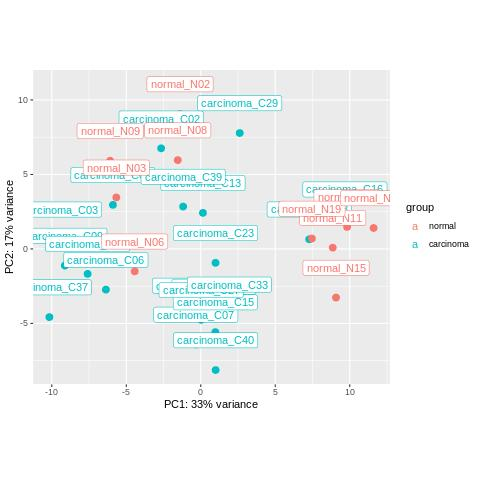

In [24]:
from IPython.display import Image

Image(filename='PCAplot.jpeg') 

<b>Q14: Do you see any obvious trends in the PCA plot?</b>


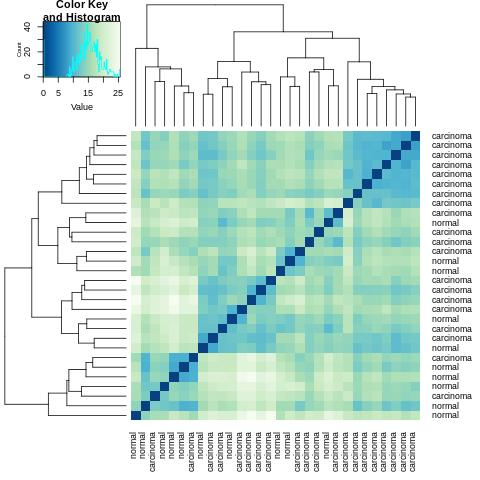

In [25]:
from IPython.display import Image

Image(filename='HM.jpeg') 

<b> Q15: When looking at the hierarchical clustering do you see any clusters? Do you see any possible outliers that would need to be excluded? </b>


***Differential expression***

Let us try to identify differentially expressed genes in the data. To do this, in the R script, we have fit a negative binomial GLM where we compare the groups specified by the condition factor (carcinoma vs. normal) (see object "sample_table" if in doubt).
The command returns a fitted model object. To get hold of the differential expression test results from this object, you can see below  a brief view of what is inside of the results.





In [26]:
import pandas as pd
df1 = pd.read_csv("res.csv")
df1

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000005238,67.836848,-0.110802,0.160569,-0.690061,0.490156,0.758206
ENSG00000010438,0.437109,-0.112180,1.562657,-0.071788,0.942770,NaN
ENSG00000011454,246.299620,0.058742,0.104600,0.561582,0.574401,0.806395
ENSG00000023318,162.252414,0.256984,0.226781,1.133179,0.257139,0.564184
ENSG00000030304,0.188529,-0.421022,2.210724,-0.190445,0.848960,NaN
...,...,...,...,...,...,...
ENSG00000261432,0.078242,0.207206,3.159149,0.065589,0.947705,NaN
ENSG00000261447,0.184549,-0.087661,2.760449,-0.031756,0.974667,NaN
ENSG00000261534,19.552481,-0.336353,0.276722,-1.215494,0.224178,0.547948
ENSG00000261696,0.000000,NaN,NaN,NaN,NaN,NaN


<b>Q16: Try to understand what is the content of the different columns of the results dataframe. What is a p-value and what is an adjusted p-value?</b>


<b>Q17: What is the log2FoldChange column?</b>



Let us order the results after the smallest adjusted p-value.




In [27]:
df1.sort_values("padj")

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000188801,19.257342,1.189394,0.297775,3.994272,0.000065,0.029051
ENSG00000225937,480.778510,3.068056,0.775504,3.956209,0.000076,0.029051
ENSG00000095303,58.538642,-1.429675,0.392299,-3.644347,0.000268,0.068179
ENSG00000041982,543.759024,-0.923905,0.285487,-3.236244,0.001211,0.084009
ENSG00000233901,10.392997,-1.226536,0.376465,-3.258035,0.001122,0.084009
...,...,...,...,...,...,...
ENSG00000261402,0.026606,-0.004382,3.160439,-0.001387,0.998894,NaN
ENSG00000261432,0.078242,0.207206,3.159149,0.065589,0.947705,NaN
ENSG00000261447,0.184549,-0.087661,2.760449,-0.031756,0.974667,NaN
ENSG00000261696,0.000000,NaN,NaN,NaN,NaN,NaN


Let us see how many genes are differentially expressed at a false discovery rate of 5%


In [28]:
## using pandas - we will see more next 

df1[df1['padj']<.05]


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000188801,19.257342,1.189394,0.297775,3.994272,0.000065,0.029051
ENSG00000225937,480.778510,3.068056,0.775504,3.956209,0.000076,0.029051



<b>Q18. How many genes are differentially expressed at a False Discovery Rate (FDR) of 5%?</b>


<b>Q19. Try to search for those genes in the Ensembl web-site. Which genes are they?</b>



<b>Q20. What is the direction and the dimension of the foldchange and what is the adjusted pvalue for PCA3?</b>

 
<b>Q21. When looking at the plot we made earlier of PCA3 (the plotCounts command) does it then make sense?</b>
